## Project Workflow
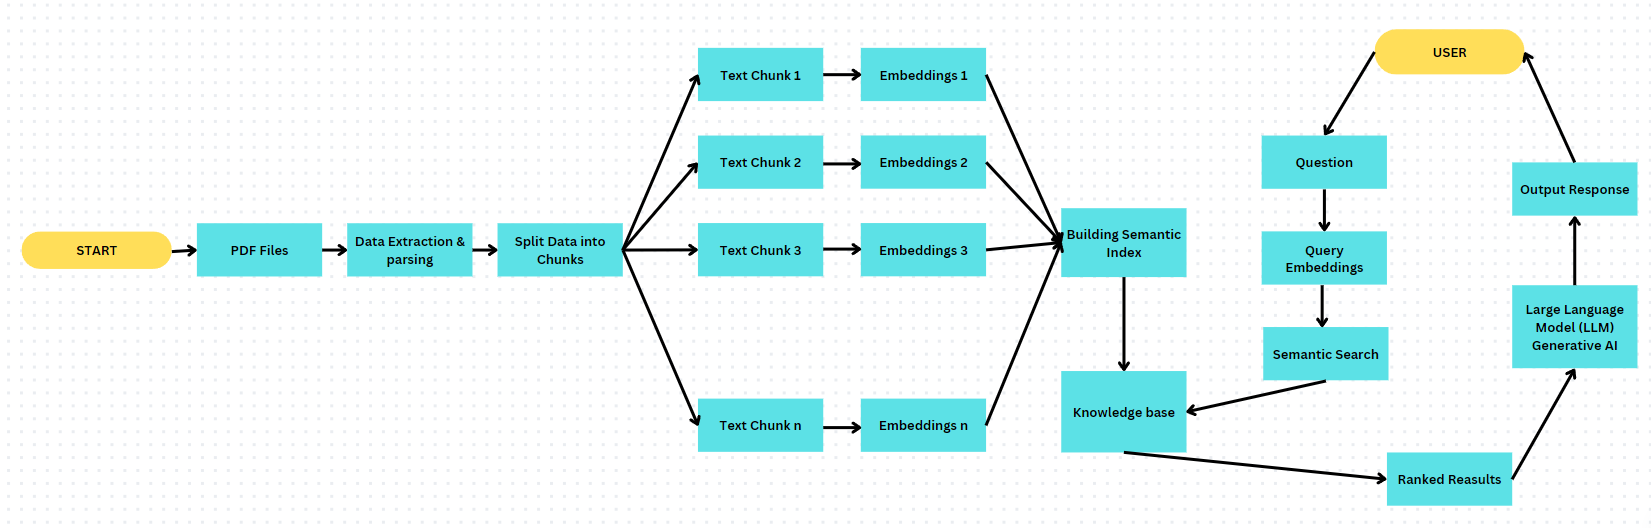

## Installing Dependencies

In [23]:
!pip install langchain
!pip install openai
!pip install PyPDF2
!pip install faiss-cpu
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.2 MB/s eta 0:00:00


## Importing Packages & initial setup

In [20]:
from PyPDF2 import PdfReader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import ElasticVectorSearch, Pinecone, Weaviate, FAISS

In [6]:
import os
# Get the API keys from https://platform.openai.com/account/api-keys
os.environ['OPENAI_API_KEY'] = 'ENTER-YOUR-OPENAI-API-KEY'

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


## Loading and Parsing PDF Document

Creating `PdfReader()` to store PDF file content.

In [9]:
data_path = '/content/gdrive/MyDrive/Colab Notebooks/Work/Gembo/Document ChatBot using KnowledgeBot using GPT-Index & LangChain/data/GEM_PRECARE_User_Manual_v2_54.pdf'
reader = PdfReader(data_path)

Extracting raw text from PDF Document.

In [10]:
raw_text = ""
for i, page in enumerate(reader.pages):
  text = page.extract_text()
  if text:
    raw_text += text

In [11]:
raw_text

' \n \n \nGEM PRECARE  \nUSER MANUAL  \n  GEM PRECARE User Manual    \n \n \n 2 \n \nGEM PRECARE User Manual  \nVersion 2.5  \nMarch 2021  \n© Copyright GEM 2021  \nThis software and documentation contain proprietary information of GEM and are provided under a \nlicense agreement containing restrictions on use and disclosure  and are also protected by copyright law. \nReverse engineering of the software is prohibited. No part of this document may be reproduced or \ntransmitted in any form, by any means (electronic, photocopying, recording or otherwise) without prior \nconsent of GEM . This Software may be protected by U.S. and/or international Patents and other Patents \nPending.  \nUse, duplication, or disclosure of the Software by the U.S. Government is subject to the restrictions set \nforth in the applicable software license agreement an d as provided in DFARS 227.7202 -1(a) and \n227.7702 -3(a) (1995), DFARS 252.227 -7013©(1)(ii) (OCT 1988), FAR 12.212(a) (1995), FAR 52.227 -19, o

## Splitting data into Chunks

Segmenting text into smaller chunks as `gpt3.5` models can only retain context of 4,096 tokens. [[ref]](https://platform.openai.com/docs/models/gpt-3-5)

In [13]:
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 1000,
    chunk_overlap = 200,
    length_function = len
)
texts = text_splitter.split_text(raw_text)

In [17]:
texts[0]

'GEM PRECARE  \nUSER MANUAL  \n  GEM PRECARE User Manual    \n \n \n 2 \n \nGEM PRECARE User Manual  \nVersion 2.5  \nMarch 2021  \n© Copyright GEM 2021  \nThis software and documentation contain proprietary information of GEM and are provided under a \nlicense agreement containing restrictions on use and disclosure  and are also protected by copyright law. \nReverse engineering of the software is prohibited. No part of this document may be reproduced or \ntransmitted in any form, by any means (electronic, photocopying, recording or otherwise) without prior \nconsent of GEM . This Software may be protected by U.S. and/or international Patents and other Patents \nPending.  \nUse, duplication, or disclosure of the Software by the U.S. Government is subject to the restrictions set \nforth in the applicable software license agreement an d as provided in DFARS 227.7202 -1(a) and \n227.7702 -3(a) (1995), DFARS 252.227 -7013©(1)(ii) (OCT 1988), FAR 12.212(a) (1995), FAR 52.227 -19, or'

In [16]:
texts[1]

'227.7702 -3(a) (1995), DFARS 252.227 -7013©(1)(ii) (OCT 1988), FAR 12.212(a) (1995), FAR 52.227 -19, or \nFAR 52.227 -14 (ALT III), as applicable.  \nThe information in this product or documentation is subject to change with out notice. If you find any \nproblems in this product or documentation, please report them to us in writing.  \nGEM and PRECARE are trademarks or registered trademarks of GEM in the United States and in \njurisdictions throughout the world. All other company and  product names may be trade names or \ntrademarks of their respective owners.  \nPortions of this software and/or documentation are subject to copyright held by third parties, including \nwithout limitation: Copyright ABC. All rights reserved. Copyright XYZ. All rights reserved.  \nThis product includes software developed by the Apache Software Foundation \n(http://www.apache.org/), and/or other software which is licensed under various versions of the'

## Converting segments of text into `OpenAI` based Word Embeddings 

In [18]:
# Creating object OpenAI embeddings
embeddings = OpenAIEmbeddings()

In [24]:
# Converts the text chunks into their respecting OpenAI vector embeddings
docsearch = FAISS.from_texts(texts, embeddings)

In [26]:
docsearch

## Creating OpenAI based Q&A model object

In [27]:
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI

In [28]:
chain = load_qa_chain(OpenAI(), chain_type="stuff")

## Performing similarity search (between query & context vector) and producing results

In [29]:
query = "Who are the author of this article?"
docs = docsearch.similarity_search(query)
chain.run(input_documents=docs, question=query)

' GEM'

In [30]:
query = "What does OEE means?"
docs = docsearch.similarity_search(query)
chain.run(input_documents=docs, question=query)

' OEE stands for Overall Equipment Effectiveness, and is a measure of the efficiency of a machine or process. It is calculated by multiplying Availability, Performance, and Quality, which are all percentages.'

In [31]:
query = "How is OEE Availability calculated?"
docs = docsearch.similarity_search(query)
chain.run(input_documents=docs, question=query)

' OEE Availability is calculated by taking the PlannedProductionTime (DeltaT minus PlannedDT) and subtracting the Sum Duration of Status events of machines (Failure+Assist+Other) in DeltaT, then dividing the result by the PlannedProductionTime in DeltaT and multiplying the result by 100.'

In [32]:
query = "What is this chat bot for?"
docs = docsearch.similarity_search(query)
chain.run(input_documents=docs, question=query)

' This chatbot is for providing information about GEM PRECARE, a cloud platform for processing GEM agent data related to machine stats, big data analytics, complex event processing, preventive and predictive maintenance OEE, MTBF, MTBA, logs, etc. It also provides information about GEM agents which allow legacy or newer machines to become a CPS, providing a digital twin representation of the physical machine in cyber space.'

# Reference:
- OpenAI pricing: https://openai.com/pricing
- OpenAI Docs: https://platform.openai.com/docs/introduction/overview
- QnA chatbot: https://platform.openai.com/docs/tutorials/web-qa-embeddings
- API Keys: https://platform.openai.com/account/api-keys
- OpenAI Usage: https://platform.openai.com/account/usage
- OpenAI models: https://platform.openai.com/docs/models